In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import arviz as az
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import theano
import theano.tensor as tt 
print(theano.config.device)

np.random.seed(42)
pm.set_tt_rng(42)


cpu


Generate Data

In [231]:
C = 32
M = 3
J = 2
K = 2
N = np.array([10000] * 100)
S = len(N)

# Hyper-parameter for priors
alpha = np.ones(C) * 0.05
psi = np.ones(J)
gamma = np.ones(K) * 0.1
beta = np.ones((K,4)) * 0.1

# cosmic signatures => no generative phi/eta
# use tau for activities
cosmic = pd.read_csv('~/data/cosmic/sigProfiler_SBS_signatures_2019_05_22.csv', index_col = [0,1]).to_numpy().T[[3, 12]]
I = cosmic.shape[0]
tau_gen = pm.Dirichlet.dist(a=np.ones(I) * 0.1).random(size = S)

In [262]:
#np.round(tau_gen, 2)

In [233]:
B=(tau_gen @ cosmic)
data = np.vstack([d.random(size = 1) for d in map(pm.Multinomial.dist, N, B)])

Preview simulated signatures

In [234]:
mut96 = ['A[C>A]A', 'A[C>A]C', 'A[C>A]G', 'A[C>A]T', 'C[C>A]A', 'C[C>A]C', 'C[C>A]G', 'C[C>A]T', 
         'G[C>A]A', 'G[C>A]C', 'G[C>A]G', 'G[C>A]T', 'T[C>A]A', 'T[C>A]C', 'T[C>A]G', 'T[C>A]T', 
         'A[C>G]A', 'A[C>G]C', 'A[C>G]G', 'A[C>G]T', 'C[C>G]A', 'C[C>G]C', 'C[C>G]G', 'C[C>G]T', 
         'G[C>G]A', 'G[C>G]C', 'G[C>G]G', 'G[C>G]T', 'T[C>G]A', 'T[C>G]C', 'T[C>G]G', 'T[C>G]T', 
         'A[C>T]A', 'A[C>T]C', 'A[C>T]G', 'A[C>T]T', 'C[C>T]A', 'C[C>T]C', 'C[C>T]G', 'C[C>T]T', 
         'G[C>T]A', 'G[C>T]C', 'G[C>T]G', 'G[C>T]T', 'T[C>T]A', 'T[C>T]C', 'T[C>T]G', 'T[C>T]T', 
         'A[T>A]A', 'A[T>A]C', 'A[T>A]G', 'A[T>A]T', 'C[T>A]A', 'C[T>A]C', 'C[T>A]G', 'C[T>A]T', 
         'G[T>A]A', 'G[T>A]C', 'G[T>A]G', 'G[T>A]T', 'T[T>A]A', 'T[T>A]C', 'T[T>A]G', 'T[T>A]T', 
         'A[T>C]A', 'A[T>C]C', 'A[T>C]G', 'A[T>C]T', 'C[T>C]A', 'C[T>C]C', 'C[T>C]G', 'C[T>C]T', 
         'G[T>C]A', 'G[T>C]C', 'G[T>C]G', 'G[T>C]T', 'T[T>C]A', 'T[T>C]C', 'T[T>C]G', 'T[T>C]T', 
         'A[T>G]A', 'A[T>G]C', 'A[T>G]G', 'A[T>G]T', 'C[T>G]A', 'C[T>G]C', 'C[T>G]G', 'C[T>G]T', 
         'G[T>G]A', 'G[T>G]C', 'G[T>G]G', 'G[T>G]T', 'T[T>G]A', 'T[T>G]C', 'T[T>G]G', 'T[T>G]T']


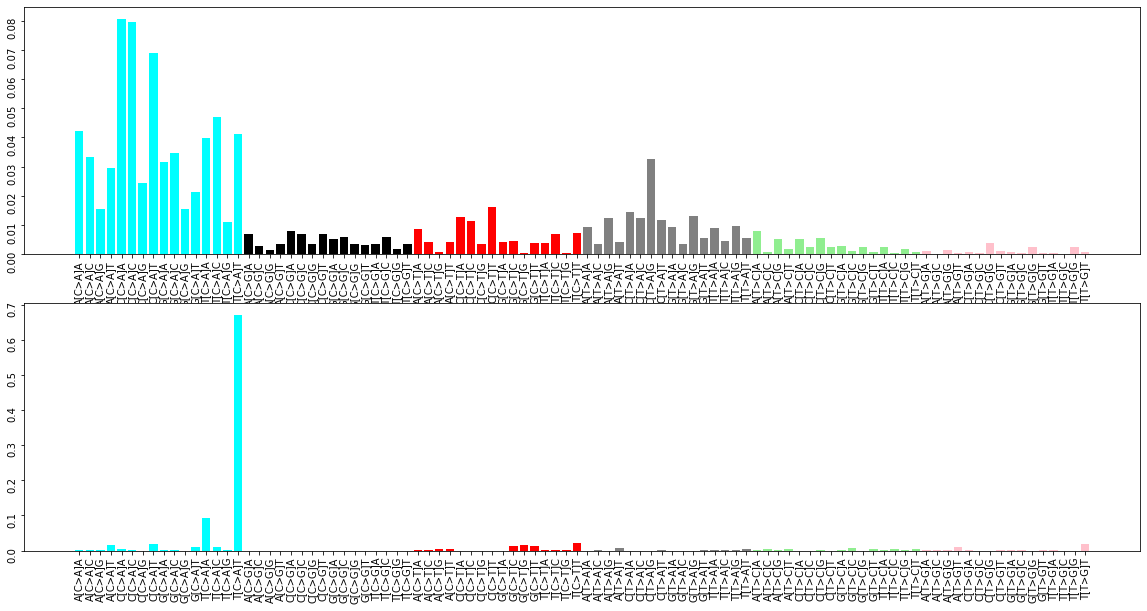

In [235]:
plt.figure(figsize=(20,10))
l=0
for i in range(I):
    l += 1
    plt.subplot(I,1,l)
    plt.bar(mut96, cosmic[i], color=np.repeat(['cyan', 'black', 'red', 'grey', 'lightgreen', 'pink'], 16))
    plt.tick_params(labelsize=10, rotation=90)

## 'collapsed' two step LDA

In [236]:
with pm.Model() as collapsed_model:

    phi = pm.Dirichlet('phi', a=alpha, shape=(J, C))
    theta = pm.Dirichlet("theta", a=psi, shape=(S, J))
    A = pm.Dirichlet("A", a=gamma, shape = (S, J, K))
    etaC = pm.Dirichlet("etaC", a=beta[:,[0,2,3]], shape=(C//2, K, M))
    etaT = pm.Dirichlet("etaT", a=beta[:,[0,1,2]], shape=(C//2, K, M))
    eta = pm.Deterministic('eta', pm.math.concatenate([etaC, etaT], axis=0))

    B = pm.Deterministic("B", (pm.math.matrix_dot(theta, phi)[:,:,None] * \
                               pm.math.matrix_dot(tt.batched_dot(theta,A),eta)).reshape((S, -1)))
    
                               
    # mutation counts
    for s in range(S):
        pm.Multinomial(f'sample_{s}', n = N[s], p = B , observed=data[s])

Fit the model with ADVI

In [237]:
with collapsed_model:
    advi_trace = pm.ADVI()
    advi_trace.fit()

Finished [100%]: Average Loss = 4.8822e+07


Diagnostic plots

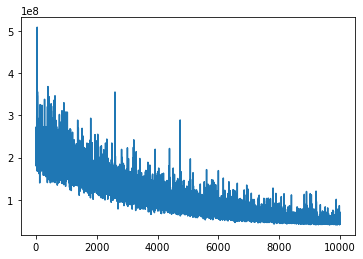

In [238]:
plt.plot(advi_trace.hist);

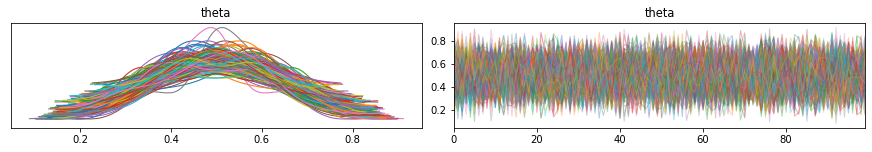

In [239]:
with collapsed_model:
    pm.plot_trace(advi_trace.approx.sample(100), var_names = 'theta');

Finished [100%]: Average Loss = 3.664e+07


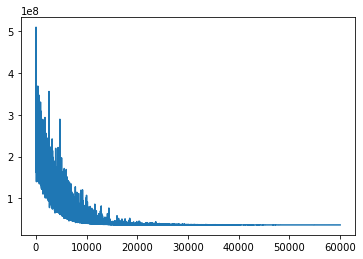

In [240]:
advi_trace.refine(50000)
plt.plot(advi_trace.hist);

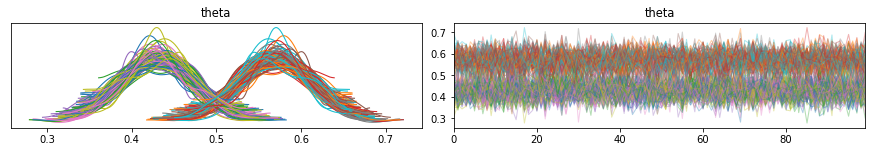

In [241]:
with collapsed_model:
    pm.plot_trace(advi_trace.approx.sample(100), var_names = 'theta');

In [242]:
#with collapsed_model:
#    az.plot_forest(advi_trace.approx.sample(300), r_hat=True);

/home/harrigan/miniconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


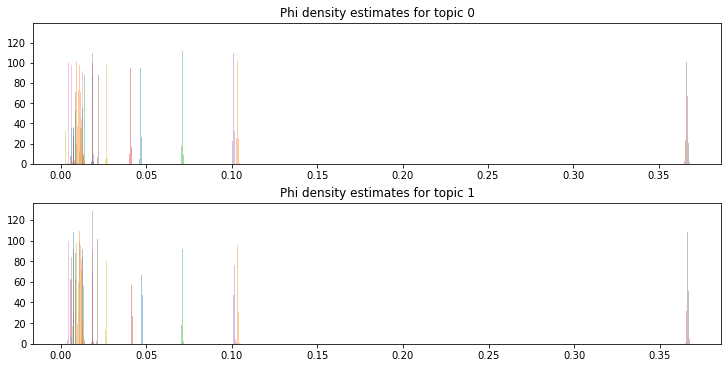

In [243]:
plt.figure(figsize=(10,5), constrained_layout = True)
for j in range(J):
    plt.subplot(J,1,j+1)
    for c in range(C):
        sns.distplot(advi_trace.approx.sample(1000)['phi'][:, j, c], kde=False, hist=True)
    plt.title(f'Phi density estimates for topic {j}')

In [244]:
advi_trace.approx.sample(100)['eta'].shape

(100, 32, 2, 3)

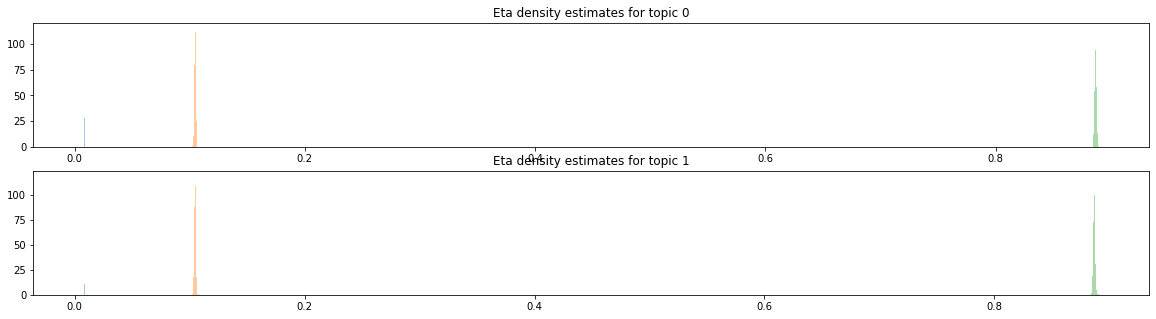

In [258]:
plt.figure(figsize=(20,5))
for k in range(K):
    plt.subplot(K,1,k+1)
    for m in range(M):
        sns.distplot(advi_trace.approx.sample(1000)['eta'][:, 31, k, m], kde=False, hist=True)
    plt.title(f'Eta density estimates for topic {k}')

In [223]:
#with collapsed_model:
#    ppc = pm.sample_posterior_predictive(advi_trace.approx.sample(100))
#    az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=collapsed_model));

<ipython-input-259-90764503ffed>:10: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


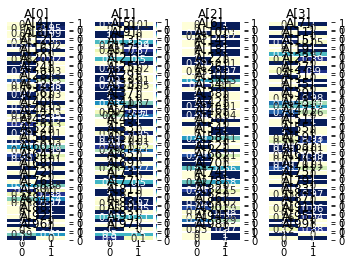

In [259]:
fig, axes = plt.subplots(nrows = S//4, ncols = 4)

s=-1
for ax in axes.flat:
    s+=1
    heat = np.round(advi_trace.approx.sample_node(A).eval()[s], 2)
    sns.heatmap(heat, ax = ax, vmin=0, vmax=1, annot=True, cmap="YlGnBu")
    ax.set_title(f"A[{s}]")

plt.tight_layout()
plt.show()

In [247]:
# requires reorder for Y>A Y>G Y>Y
yy_to_mutsig = np.array([ 0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45,
                         1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 
                         2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 
                         48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 
                         49, 52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94, 
                         50, 53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89, 92, 95])

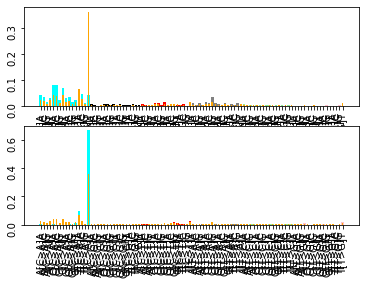

In [248]:
with collapsed_model:
    
    phi_hat=advi_trace.approx.sample_node(phi).eval()
    eta_hat=advi_trace.approx.sample_node(eta).eval()
    
    sig_hat = np.vstack([np.outer(phi_hat[j,c], eta_hat[c,k,:]) \
                for j in range(J) for k in range(K) for c in range(C)]).reshape(J, K, -1)

    l=0
    for i in range(I):
        l += 1
        plt.subplot(I,1,l)
        plt.bar(mut96, cosmic[i], color=np.repeat(['cyan', 'black', 'red', 'grey', 'lightgreen', 'pink'], 16))
        plt.bar(mut96, sig_hat.reshape(-1, 96)[i], color='orange', width = 0.5)
        plt.tick_params(labelsize=10, rotation=90)

```
yy = np.vstack([np.outer(advi_trace.approx.sample(1)['phi'][:,j,c], \
                         advi_trace.approx.sample(1)['eta'][:,c,k,:]) \
                for j in range(J) for k in range(K) for c in range(C)]).reshape(J, K, -1)

mutsig = np.array([yy[j][k][yy_to_mutsig] for j in range(J) for k in range(K)]).reshape(J, K, -1)
```

```
plt.figure(figsize=(20,10))
i=0
for j in range(J):
    for k in range(K):
        i += 1
        plt.subplot(J*K,1,i)
        plt.bar(mut96, mutsig[j,k], color=np.repeat(['cyan', 'black', 'red', 'grey', 'lightgreen', 'pink'], 16))
        #plt.tick_params(bottom=False,labelbottom=False
        plt.tick_params(labelsize=10, rotation=90)
```

In [ ]:
with collapsed_model:
    phi_map = pm.find_MAP()['phi']
    print(np.diag(cosine_similarity(phi_map, phi_gen)))